In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.measure import label, regionprops
from skimage.feature import local_binary_pattern
from skimage.feature import hog
from skimage import data, exposure
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier 
from sklearn import neighbors
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn import metrics

from sklearn.utils.multiclass import unique_labels
from time import time
from matplotlib import offsetbox
import seaborn as sns

## Loading data

In [2]:
# data-loading
images = np.load('/mnt/e/Pattern Recognition/DigitRecognizer/data/images.npy')
labels = np.load('/mnt/e/Pattern Recognition/DigitRecognizer/data/labels.npy')

## EDA

In [ ]:
df_train=pd.DataFrame(labels[:50000], columns=['class'])
sns.set(style="darkgrid")
ax = sns.countplot(x='class', data=df_train)

In [ ]:
df_test=pd.DataFrame(labels[50000:], columns=['class'])
sns.set(style="darkgrid")
ax = sns.countplot(x='class', data=df_test)

## Creating binary images by applying adaptive thresholding

In [3]:
#binary images
from skimage.filters import threshold_local
thresh_images = np.zeros(images.shape, dtype='uint')


for i in range(len(thresh_images)):
    
    threshed = np.zeros((28, 28), dtype='uint')
    im = images[i, :, :]
    
    
    threshed[im<80] = 1
    threshed[im>80] = 0
    
    thresh_images[i, :, :] = threshed
    
     

## Thresholded digit demonstration

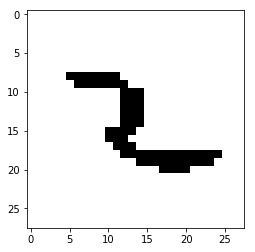

In [4]:
plt.imshow(thresh_images[558,:,:], cmap='gray')

## Creating HOG feature vector for dimentionality reduction

In [5]:
hog_results = np.zeros((392, 60000), dtype='float64')
hog_image = np.zeros((28, 28, 60000))
for i in range(60000):
    hog_results[:, i], hog_image[:, :, i] = hog(thresh_images[i, :, :], orientations=8, pixels_per_cell=(4, 4),
                            cells_per_block=(1, 1), visualize=True, multichannel=False, block_norm = 'L2-Hys')


## Visualization of HOG features of different classes

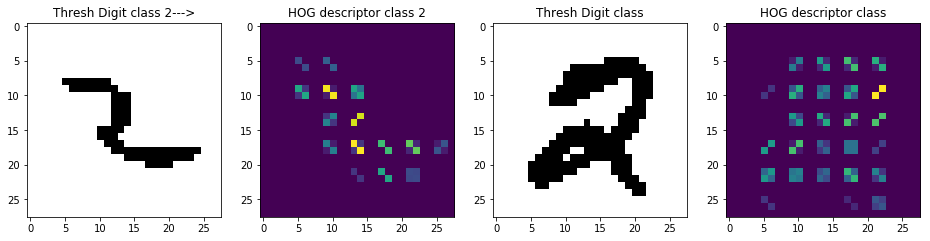

In [7]:
plt.figure(1, figsize=(16,16))

plt.subplot(141, title='Thresh Digit class 2--->')
plt.imshow(thresh_images[558,:,:], cmap='gray')

plt.subplot(142, title='HOG descriptor class 2')
plt.imshow(hog_image[:,:,558])

plt.subplot(143, title='Thresh Digit class 2 -->')
plt.imshow(thresh_images[23001,:,:], cmap='gray')

plt.subplot(144, title='HOG descriptor class 2')
plt.imshow(hog_image[:,:,23001])

plt.show()

## To visualize our high-dimentional HOG matrix, lets use t-distributed Stochastic Neighbor Embedding

In [7]:
X = np.transpose(hog_results)
y = labels
n_samples, n_features = X.shape
n_neighbors = 30

In [8]:
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(hog_results[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

Computing t-SNE embedding


TypeError: Invalid dimensions for image data

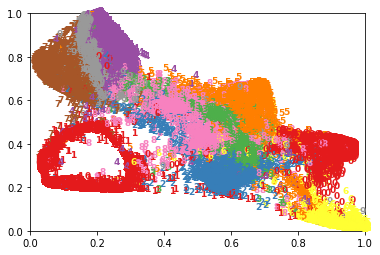

In [11]:
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = TSNE(n_components=2, perplexity=50, early_exaggeration = 10.0, learning_rate = 175, n_iter = 250, init='pca', random_state=0)

X_tsne = tsne.fit_transform(X)

plot_embedding(X_tsne)

plt.show()
np.save('./X_tsne.npy',X_tsne)

In [ ]:
hog_results.shape

## Next step is to implement Voting Classifiers : SGD classifier, Random Forest and SVC 

In [ ]:
#split dataset into training and test sets
X = np.transpose(hog_results)
y = labels
X_train, X_test, y_train, y_test = X[:50000], X[50000:], y[:50000], y[50000:]

In [ ]:
#SGD classifier
sgd_clf = SGDClassifier(random_state=55, validation_fraction=0.2, verbose = 0, max_iter=100, n_jobs=30, shuffle=True)


#Random Forest Classifier to compare the results
randfor_clf = RandomForestClassifier(n_estimators=100, random_state=55, n_jobs=30)

#SVC with RBF kernel  
svc_clf = SVC(kernel='rbf',gamma='auto',random_state=55)

In [ ]:
#ensemble of classifiers(Voting)

clf1 = sgd_clf
clf2 = randfor_clf
clf3 = svc_clf
eclf1 = VotingClassifier(estimators=[('sgd', clf1), ('rf', clf2), ('svc', clf3)], voting='hard')

In [ ]:
eclf1 = eclf1.fit(X_train, y_train)

#### Testing 

In [ ]:
expected = y_test
predicted = eclf1.predict(X_test)

print("Classification report for classifier %s:\n%s\n"
      % (eclf1, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

#### plotting results

#### confusion matrices

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
class_names = np.array([0,1,2,3,4,5,6,7,8,9])
plot_confusion_matrix(expected, predicted, classes=class_names,
                      title='Confusion matrix, without normalization')

#### Plotting predicted digits 

In [ ]:
images_and_predictions = list(zip(thresh_images[50000:, :,:], predicted))
for index, (image, prediction) in enumerate(images_and_predictions[:4]):
    plt.subplot(2, 4, index + 5)
    plt.axis('off')
    plt.imshow(image, cmap='gray', interpolation='nearest')
    plt.title('Prediction: %i' % prediction)

plt.show()

In [ ]:
images_and_predictions = list(zip(hog_image[:,:,50000:], predicted))
for index, (image, prediction) in enumerate(images_and_predictions[:4]):
    plt.subplot(2, 4, index + 5)
    plt.axis('off')
    plt.imshow(image)
    plt.title('Prediction: %i' % prediction)

plt.show()

#### tSNE HOG features visualization 

In [ ]:
tsne = np.load('/mnt/e/Pattern Recognition/DigitRecognizer/Digit-Recognizer/X_tsne.npy')

In [ ]:
tsne.shape

In [ ]:
y = labels
plot_embedding(tsne[:10000], title = 'tSNE dimentionality reduction visualization')

plt.show()

In [ ]:
svc_clf = SVC(kernel='rbf',gamma='auto',random_state=55)
cross_val_score(svc_clf, tsne[:50000, :], y_train, cv=3, scoring='accuracy')